In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, Conv1D, MaxPooling1D
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
import pandas as pd
import numpy as np
np.random.seed(0)
from nltk import word_tokenize
from gensim.models import word2vec
import talos as ta
from keras.layers import Dropout
from talos.model.early_stopper import early_stopper
from talos.model.normalizers import lr_normalizer
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt



Using TensorFlow backend.
/Users/roberthillery/anaconda3/envs/venv/lib/python2.7/site-packages/chances/plots.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/roberthillery/anaconda3/envs/venv/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/Users/roberthillery/anaconda3/envs/venv/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/Users/roberthillery/anaconda3/envs/venv/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/roberthillery/anaconda3/envs/venv/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_in

In [2]:
%matplotlib inline



In [3]:
df = pd.read_csv('updated_target_merged_data.csv')

df.head()

,Date,retweet_from,tweet_length,encoded_sentiment,polarity,tweet,pc_1,pc_2,pc_3,pc_4,...,pc_30,pc_31,pc_32,pc_33,pc_34,pc_35,pc_36,pc_37,pc_38,signal_y
0,2017-09-29,171,105,1,0.366667,assuming acceleration of to but in a comfortab...,-0.031750,-0.028862,-0.030268,-0.018790,...,-0.034915,-0.030453,0.009013,-0.004715,-0.074266,-0.084025,0.019334,-0.004746,0.025779,down
1,2017-09-29,77,113,1,0.200000,is capable of transporting satellite to orbit ...,-0.059331,-0.099826,-0.154760,-0.040333,...,-0.015897,0.009704,-0.011633,-0.016697,-0.033227,0.000195,0.011908,-0.017864,-0.001426,down
2,2017-09-29,171,6,0,0.000000,yup,-0.002330,0.033960,0.069607,-0.014126,...,0.012970,-0.008978,-0.013865,0.046525,-0.007867,0.041954,-0.034317,-0.085269,-0.029201,down
3,2017-09-29,171,7,0,0.000000,part,-0.005050,0.024122,0.043361,-0.001799,...,-0.000544,-0.003106,-0.009162,-0.007540,0.008748,0.016646,-0.003052,-0.056231,-0.018816,down
4,2017-09-29,171,96,1,0.650000,fly to most place on earth in under min and an...,-0.031167,-0.027728,-0.012339,-0.039902,...,-0.000036,-0.000197,-0.007578,0.083160,-0.010546,-0.022204,-0.059491,0.048438,0.023978,down


In [4]:
df_pca = pd.read_csv('pca_updated_data.csv')

In [5]:
df_1 = df[['Date', 'retweet_from', 'tweet_length', 'encoded_sentiment', 'polarity', 'tweet', 'signal_y']]


In [6]:
df_2 = pd.concat([df_1, df_pca], axis=1)

In [7]:
df_2 = df_2.drop(columns=['Unnamed: 0'])

In [9]:
df_2.head()

,Date,retweet_from,tweet_length,encoded_sentiment,polarity,tweet,signal_y,0,1,2,...,790,791,792,793,794,795,796,797,798,799
0,2017-09-29,171,105,1,0.366667,assuming acceleration of to but in a comfortab...,down,-0.031750,-0.028860,-0.030273,...,-0.014750,0.006987,-0.018947,0.003795,0.021159,0.007026,-0.077665,-0.005893,0.020216,-0.024430
1,2017-09-29,77,113,1,0.200000,is capable of transporting satellite to orbit ...,down,-0.059331,-0.099827,-0.154757,...,0.003511,-0.017758,-0.007694,0.003239,0.015531,0.019036,0.019721,0.019111,-0.011908,0.000386
2,2017-09-29,171,6,0,0.000000,yup,down,-0.002330,0.033969,0.069578,...,0.000253,0.001255,-0.001372,-0.001781,0.001782,0.001916,-0.002330,-0.002583,-0.001100,0.000627
3,2017-09-29,171,7,0,0.000000,part,down,-0.005050,0.024121,0.043358,...,-0.001174,-0.005936,-0.005910,0.017547,-0.001422,-0.002220,0.004902,0.000039,0.011071,0.011174
4,2017-09-29,171,96,1,0.650000,fly to most place on earth in under min and an...,down,-0.031167,-0.027728,-0.012323,...,0.003524,0.002561,-0.003482,0.002877,-0.018114,-0.014788,-0.011140,0.006785,0.002626,0.015714


## Scale the data

we are scaling retweets_from and tweet_length

In [10]:
scaler = StandardScaler()

In [11]:
df_2[['retweet_from', 'tweet_length']] = scaler.fit_transform(df[['retweet_from', 'tweet_length']])



In [12]:
df_2.head()

,Date,retweet_from,tweet_length,encoded_sentiment,polarity,tweet,signal_y,0,1,2,...,790,791,792,793,794,795,796,797,798,799
0,2017-09-29,0.375794,0.748184,1,0.366667,assuming acceleration of to but in a comfortab...,down,-0.031750,-0.028860,-0.030273,...,-0.014750,0.006987,-0.018947,0.003795,0.021159,0.007026,-0.077665,-0.005893,0.020216,-0.024430
1,2017-09-29,-2.297408,0.946045,1,0.200000,is capable of transporting satellite to orbit ...,down,-0.059331,-0.099827,-0.154757,...,0.003511,-0.017758,-0.007694,0.003239,0.015531,0.019036,0.019721,0.019111,-0.011908,0.000386
2,2017-09-29,0.375794,-1.700349,0,0.000000,yup,down,-0.002330,0.033969,0.069578,...,0.000253,0.001255,-0.001372,-0.001781,0.001782,0.001916,-0.002330,-0.002583,-0.001100,0.000627
3,2017-09-29,0.375794,-1.675616,0,0.000000,part,down,-0.005050,0.024121,0.043358,...,-0.001174,-0.005936,-0.005910,0.017547,-0.001422,-0.002220,0.004902,0.000039,0.011071,0.011174
4,2017-09-29,0.375794,0.525590,1,0.650000,fly to most place on earth in under min and an...,down,-0.031167,-0.027728,-0.012323,...,0.003524,0.002561,-0.003482,0.002877,-0.018114,-0.014788,-0.011140,0.006785,0.002626,0.015714


In [13]:
df_2.tweet = df.tweet.astype(str)

## Check the class balance of our target classes

In [14]:
target = df.signal_y

In [15]:
target.head()

0    down
1    down
2    down
3    down
4    down
Name: signal_y, dtype: object

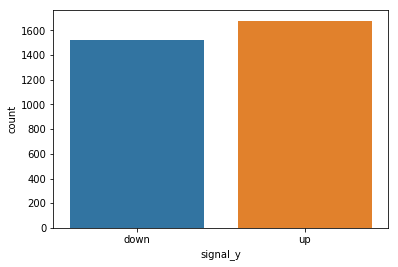

In [16]:
sns.countplot(df['signal_y'])

# Exploratory Data Analysis

In [17]:
df_graph = df_2[['tweet']]

df_graph['tweet_length'] = df_2['tweet'].apply(len)

df_graph['encoded_sentiment'] = df_2['encoded_sentiment']

df_graph['target'] = target

df_graph.head()

,tweet,tweet_length,encoded_sentiment,target
0,assuming acceleration of to but in a comfortab...,83,1,down
1,is capable of transporting satellite to orbit ...,94,1,down
2,yup,3,0,down
3,part,4,0,down
4,fly to most place on earth in under min and an...,85,1,down


In [18]:
df_graph['tweet_length'].describe()

count    3205.000000
mean       57.876443
std        33.344703
min         1.000000
25%        30.000000
50%        59.000000
75%        85.000000
max       136.000000
Name: tweet_length, dtype: float64

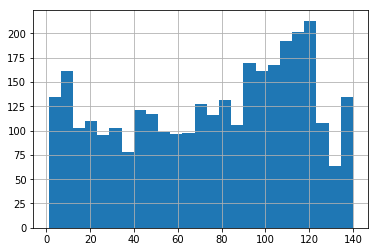

In [19]:
df['tweet_length'].hist(bins = 25)

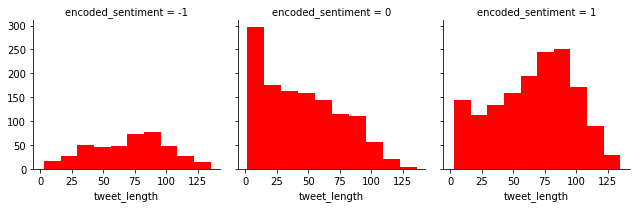

In [20]:
sentiment_graph = sns.FacetGrid(df_graph,col='encoded_sentiment')
sentiment_graph.map(plt.hist,'tweet_length', color='r')



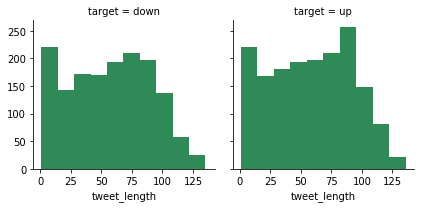

In [21]:
target_graph = sns.FacetGrid(df_graph,col='target')
target_graph.map(plt.hist,'tweet_length', color='seagreen')

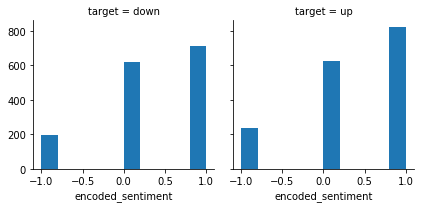

In [22]:
target_sentiment_graph = sns.FacetGrid(df_graph,col='target')
target_sentiment_graph.map(plt.hist,'encoded_sentiment')

# ANN Model for non tweet features

Make the dataframe for not tweet features, which include the tf-idf of the tweets.


In [23]:
y = pd.get_dummies(target).values

In [24]:
print(type(y))
y[:4]

<type 'numpy.ndarray'>


array([[1, 0],
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [25]:
df_no_tweet = df_2.drop(['signal_y', 'tweet', 'Date'], axis=1)

In [26]:
df_no_tweet.head()

,retweet_from,tweet_length,encoded_sentiment,polarity,0,1,2,3,4,5,...,790,791,792,793,794,795,796,797,798,799
0,0.375794,0.748184,1,0.366667,-0.031750,-0.028860,-0.030273,-0.018769,-0.060676,0.057752,...,-0.014750,0.006987,-0.018947,0.003795,0.021159,0.007026,-0.077665,-0.005893,0.020216,-0.024430
1,-2.297408,0.946045,1,0.200000,-0.059331,-0.099827,-0.154757,-0.040344,0.072303,0.209183,...,0.003511,-0.017758,-0.007694,0.003239,0.015531,0.019036,0.019721,0.019111,-0.011908,0.000386
2,0.375794,-1.700349,0,0.000000,-0.002330,0.033969,0.069578,-0.014138,-0.037713,-0.071401,...,0.000253,0.001255,-0.001372,-0.001781,0.001782,0.001916,-0.002330,-0.002583,-0.001100,0.000627
3,0.375794,-1.675616,0,0.000000,-0.005050,0.024121,0.043358,-0.001800,-0.016294,-0.051990,...,-0.001174,-0.005936,-0.005910,0.017547,-0.001422,-0.002220,0.004902,0.000039,0.011071,0.011174
4,0.375794,0.525590,1,0.650000,-0.031167,-0.027728,-0.012323,-0.039920,-0.070452,0.019524,...,0.003524,0.002561,-0.003482,0.002877,-0.018114,-0.014788,-0.011140,0.006785,0.002626,0.015714


In [27]:
# these are the features for the no_tweet ANN model
X = df_no_tweet.drop(columns=['encoded_sentiment']).as_matrix()

In [31]:
X[0].shape

(803,)

In [32]:
X.shape

(3205, 803)

In [33]:
X

array([[ 3.75793919e-01,  7.48184035e-01,  3.66666667e-01, ...,
        -5.89298127e-03,  2.02159374e-02, -2.44296936e-02],
       [-2.29740768e+00,  9.46045275e-01,  2.00000000e-01, ...,
         1.91110158e-02, -1.19081575e-02,  3.86021435e-04],
       [ 3.75793919e-01, -1.70034881e+00,  0.00000000e+00, ...,
        -2.58264620e-03, -1.09961019e-03,  6.27378001e-04],
       ...,
       [ 3.75793919e-01,  1.51489634e+00,  0.00000000e+00, ...,
         1.65888690e-03, -1.63609806e-02, -5.67280705e-03],
       [ 3.75793919e-01,  9.21312620e-01,  4.00000000e-01, ...,
         4.86410501e-04,  1.16638269e-02, -2.17394909e-02],
       [-3.29274870e+00, -4.63716060e-01,  0.00000000e+00, ...,
         2.96719122e-02, -6.37942781e-03,  2.21324532e-02]])

In [34]:
# this is check the target for the Neural Network
print(type(y))

<type 'numpy.ndarray'>


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)


In [36]:
classifier = Sequential()
classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'tanh'))
classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'tanh'))
classifier.add(Dense(units = 2, kernel_initializer='uniform', activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
c = classifier.fit(X_train, y_train, batch_size = 10, epochs = 4, validation_split=0.1)


Train on 2307 samples, validate on 257 samples
Epoch 1/4
2307/2307 [==============================] - 2s 890us/step - loss: 0.6933 - acc: 0.5178 - val_loss: 0.6907 - val_acc: 0.5720
Epoch 2/4
2307/2307 [==============================] - 1s 507us/step - loss: 0.6841 - acc: 0.5494 - val_loss: 0.6892 - val_acc: 0.5409
Epoch 3/4
2307/2307 [==============================] - 1s 550us/step - loss: 0.6123 - acc: 0.6673 - val_loss: 0.7327 - val_acc: 0.5370
Epoch 4/4
2307/2307 [==============================] - 1s 512us/step - loss: 0.5527 - acc: 0.7193 - val_loss: 0.8123 - val_acc: 0.5409


In [37]:
score_no_tweet, acc_no_tweet = classifier.evaluate(X_test, y_test, verbose = 2, batch_size = 32)
print("score for the test data no tweet model: %.3f" % (score_no_tweet))
print("acc for the test data  no tweet model: %.7f" % (acc_no_tweet))

score_train_no_tweet, acc_train_no_tweet = classifier.evaluate(X_train, y_train, verbose = 2, batch_size = 32)
print("score for the training data no tweet model: %.3f" % (score_train_no_tweet))
print("acc for the training data no tweet model: %.7f" % (acc_train_no_tweet))

score for the test data no tweet model: 0.829
acc for the test data  no tweet model: 0.4914197
score for the training data no tweet model: 0.530
acc for the training data no tweet model: 0.7388846


The neural network for the non-tweet data has a 73% accuracy rate.

In [38]:
def plot_train_val(model, label):
    plt.plot(model.history[label]) 
    plt.plot(model.history['val_' +label])
    plt.title('model '+label)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.gca().legend(('train','val'))
    return plt.show()

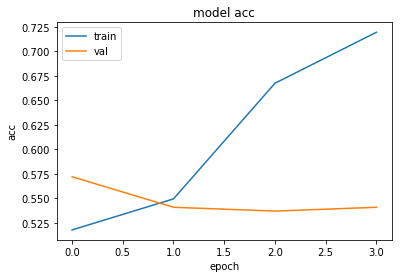

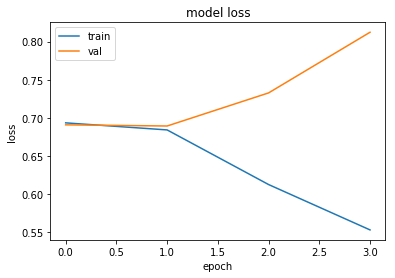

(None, None)

In [39]:
plot_train_val(c, 'acc'), plot_train_val(c, 'loss')

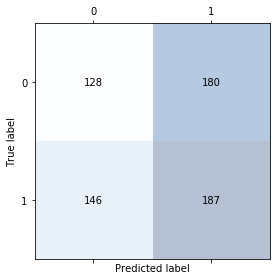

In [40]:
y_pred_test_classifier =  classifier.predict_classes(X_test, batch_size=20, verbose=0)
confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test_classifier)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# ANN Model with tweets included

First, tokenize the tweets to feed into the model.

In [41]:
# set the tweet column to a string to account of data type errors
df_2.tweet = df_2.tweet.astype(str)

In [42]:
tokenizer = text.Tokenizer(num_words=15000)
tokenizer.fit_on_texts(list(df_2.tweet))
list_tokenized_tweets = tokenizer.texts_to_sequences(df_2.tweet)
X_t = sequence.pad_sequences(list_tokenized_tweets) 


In [43]:
print(type(X_t))
print(X_t.shape)
X_t[:3]

<type 'numpy.ndarray'>
(3205, 28)


array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 1328,  711,    4,    2,   16,    6,    3, 1633, 1329,
          12,  351,   36,    3, 2220,    2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    5,
         712,    4, 1634,  156,    2,  151,  394,    9,  461,    2,    1,
           9,  127,    2,    1,  276,   47],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,  505]], dtype=int32)

In [45]:
print(type(X))
print(X.shape)
X[:1].shape

<type 'numpy.ndarray'>
(3205, 803)


(1, 803)

In [46]:
X_try = np.append(X_t, X, axis=1)

In [47]:
X_try.shape

(3205, 831)

In [48]:
# use X_try because it combines tweets vectors and pca vectors
X_try[0].shape

(831,)

In [49]:
X_train_tweet, X_test_tweet, y_train_tweet, y_test_tweet = train_test_split(X_try, y, test_size = 0.2, random_state = 0)



In [50]:
classifier = Sequential()
classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'relu'))
classifier.add(Dense(units = 15, kernel_initializer='uniform', activation = 'relu'))
classifier.add(Dense(units = 2, kernel_initializer='uniform', activation = 'softmax'))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann = classifier.fit(X_train_tweet, y_train_tweet, batch_size = 10, epochs = 4, validation_split=0.1)


Train on 2307 samples, validate on 257 samples
Epoch 1/4
2307/2307 [==============================] - 2s 1ms/step - loss: 0.6985 - acc: 0.4939 - val_loss: 0.6879 - val_acc: 0.5681
Epoch 2/4
2307/2307 [==============================] - 2s 704us/step - loss: 0.6926 - acc: 0.5100 - val_loss: 0.6862 - val_acc: 0.5875
Epoch 3/4
2307/2307 [==============================] - 2s 764us/step - loss: 0.6885 - acc: 0.5221 - val_loss: 0.6822 - val_acc: 0.5720
Epoch 4/4
2307/2307 [==============================] - 1s 555us/step - loss: 0.6866 - acc: 0.5186 - val_loss: 0.6768 - val_acc: 0.6109


In [51]:
score_train_tweet, acc_train_tweet = classifier.evaluate(X_train_tweet, y_train_tweet, verbose = 2, batch_size = 32)
print("score for train no tweet model: %.2f" % (score_train_tweet))
print("acc for no train tweet model: %.2f" % (acc_train_tweet))

score for train no tweet model: 0.67
acc for no train tweet model: 0.55


In [52]:
score_tweet, acc_tweet = classifier.evaluate(X_test_tweet, y_test_tweet, verbose = 2, batch_size = 32)
print("score: %.2f" % (score_tweet))
print("acc: %.2f" % (acc_tweet))


score: 0.70
acc: 0.52


The neural network for tweets and pca has a 52% accuracy rate.

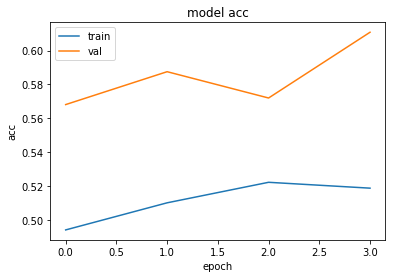

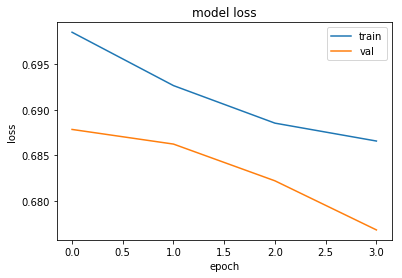

(None, None)

In [53]:
plot_train_val(ann, 'acc'), plot_train_val(ann, 'loss')

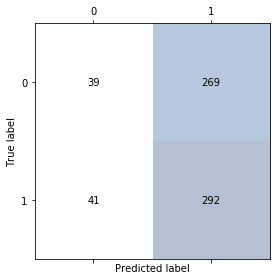

In [54]:
y_pred_test_classifier =  classifier.predict_classes(X_test_tweet, batch_size=20, verbose=0)
confmat = confusion_matrix(np.argmax(y_test_tweet,axis=1), y_pred_test_classifier)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# A RNN

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, train_test_split
from keras.models import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding, SpatialDropout1D, SimpleRNN
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D, RNN
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
import pandas as pd
import numpy as np
np.random.seed(0)
from nltk import word_tokenize
from gensim.models import word2vec

In [56]:
max_fatures = 3000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df_2['tweet'].values)
X = tokenizer.texts_to_sequences(df_2['tweet'].values)
X = pad_sequences(X)

In [57]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 28, 128)           384000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 28, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 394       
Total params: 639,194
Trainable params: 639,194
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
y = pd.get_dummies(df['signal_y']).values
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size = 0.20, random_state = 42)
print(X_train_2.shape, y_train_2.shape)
print(X_test_2.shape, y_test_2.shape)

((2564, 28), (2564, 2))
((641, 28), (641, 2))


In [60]:
#model.fit(X_train_2, y_train_2, epochs=20, validation_split=0.1, batch_size=42, verbose=2)

In [57]:
score,acc = model.evaluate(X_test_2, y_test_2, verbose = 2, batch_size = 32)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 2.29
acc: 0.51


In [61]:
# plot_train_val(model, 'acc'), plot_train_val(model, 'loss')

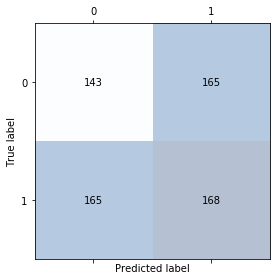

In [59]:
y_pred_test_model =  model.predict_classes(X_test_2, batch_size=20, verbose=0)
confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test_model)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# Next NN

In [62]:
# delete kernel_initializer
model2 = Sequential()
model2.add(Dense(20, input_dim=803, kernel_initializer='normal', activation='tanh'))
model2.add(Dense(20, kernel_initializer='normal', activation='tanh'))
model2.add(Dropout(0.01))
model2.add(Dense(20, kernel_initializer='normal', activation='tanh'))
model2.add(Dropout(0.01))
model2.add(Dense(20, kernel_initializer='normal', activation='tanh'))
model2.add(Dropout(0.01))
model2.add(Dense(20, kernel_initializer='normal', activation='tanh'))
model2.add(Dense(10, activation='tanh'))
model2.add(Dense(10, activation='tanh'))
model2.add(Dense(2, activation='softmax'))
adam2 = optimizers.Adam(lr=.05, decay=0.0005)
model2.compile(loss='binary_crossentropy', optimizer=adam2, metrics=['accuracy'])
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 20)                16080     
_________________________________________________________________
dense_9 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
__________

In [63]:
X_train

array([[ 3.75793919e-01, -1.77454677e+00,  0.00000000e+00, ...,
         4.94559878e-04,  5.32328272e-04, -2.12158806e-04],
       [-2.01302453e+00, -2.16389510e-01,  0.00000000e+00, ...,
         1.92538368e-02,  9.05187287e-03,  7.82657489e-03],
       [-2.41116094e+00,  3.77194210e-01,  0.00000000e+00, ...,
         1.27178124e-02,  4.41299629e-03,  1.39968074e-02],
       ...,
       [-2.29740768e+00,  9.70777930e-01,  3.18750000e-01, ...,
        -1.17874800e-03,  1.87006026e-02, -1.64434519e-02],
       [ 3.75793919e-01,  4.51392175e-01,  0.00000000e+00, ...,
        -2.61378840e-03,  3.95667890e-03,  1.16051891e-02],
       [ 3.75793919e-01,  5.56696952e-02, -6.25000000e-02, ...,
        -2.63154701e-02,  6.95727437e-04,  1.16607184e-02]])

In [64]:
m2 = model2.fit(X_train, y_train, epochs=7, validation_split=.1, batch_size=20, verbose=1)




Train on 2307 samples, validate on 257 samples
Epoch 1/7
2307/2307 [==============================] - 3s 1ms/step - loss: 0.7081 - acc: 0.5087 - val_loss: 0.7197 - val_acc: 0.5642
Epoch 2/7
2307/2307 [==============================] - 1s 494us/step - loss: 0.7060 - acc: 0.5017 - val_loss: 0.7329 - val_acc: 0.4358
Epoch 3/7
2307/2307 [==============================] - 1s 538us/step - loss: 0.7005 - acc: 0.4957 - val_loss: 0.6927 - val_acc: 0.5642
Epoch 4/7
2307/2307 [==============================] - 1s 513us/step - loss: 0.7312 - acc: 0.4931 - val_loss: 0.7009 - val_acc: 0.5642
Epoch 5/7
2307/2307 [==============================] - 1s 583us/step - loss: 0.7220 - acc: 0.4905 - val_loss: 0.7303 - val_acc: 0.4358
Epoch 6/7
2307/2307 [==============================] - 1s 465us/step - loss: 0.7200 - acc: 0.5061 - val_loss: 0.6869 - val_acc: 0.5720
Epoch 7/7
2307/2307 [==============================] - 1s 459us/step - loss: 0.7230 - acc: 0.4905 - val_loss: 0.6851 - val_acc: 0.5642


In [63]:
# score for the test data no tweet model: 0.6923892
# acc for the test data  no tweet model: 0.5195008
# score for the training data no tweet model: 0.6919532
# acc for the training data no tweet model: 0.5247660

In [65]:
model_2_score_no_tweet, model_2_acc_no_tweet = model2.evaluate(X_test, y_test, verbose = 2, batch_size = 32)
print("score for the test data no tweet model: %.7f" % (model_2_score_no_tweet))
print("acc for the test data  no tweet model: %.7f" % (model_2_acc_no_tweet))

model_2_score_train_no_tweet, model_2_acc_train_no_tweet = model2.evaluate(X_train, y_train, verbose = 2, batch_size = 32)
print("score for the training data no tweet model: %.7f" % (model_2_score_train_no_tweet))
print("acc for the training data no tweet model: %.7f" % (model_2_acc_train_no_tweet))

score for the test data no tweet model: 0.6937866
acc for the test data  no tweet model: 0.5163807
score for the training data no tweet model: 0.6939996
acc for the training data no tweet model: 0.5138456


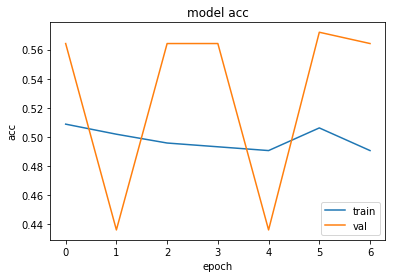

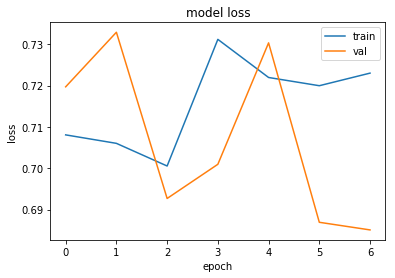

(None, None)

In [66]:
plot_train_val(m2, 'acc'), plot_train_val(m2, 'loss')

In [67]:
y_pred_test_model2 =  model2.predict_classes(X_test, batch_size=20, verbose=0)

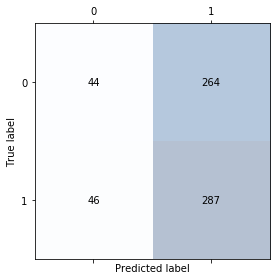

In [68]:
confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test_model2)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# Another NN

In [68]:
# classifier2 = Sequential()
# randuni = initializers.VarianceScaling(scale=.375, distribution='normal', seed=None) # RandomUniform(minval=-0.05, maxval=0.05, seed=None)
# classifier2.add(Dense(15, kernel_initializer=randuni, activation = 'tanh'))
# classifier2.add(Dense(20, activation = 'tanh'))
# # classifier2.add(Dense(15, activation = 'tanh'))
# # classifier2.add(Dense(50, kernel_regularizer=regularizers.l1(0.05), activation='tanh'))
# # classifier2.add(Dense(10, kernel_regularizer=regularizers.l1(0.05), activation='tanh'))
# classifier.add(Dense(5, kernel_regularizer=regularizers.l1(0.05), activation='relu'))
# classifier.add(Dense(5, activation = 'tanh'))
# classifier.add(Dense(5, activation = 'tanh'))
# classifier2.add(Dense(2, activation = 'softmax'))
# adam = optimizers.Adam(lr=.0001)
# classifier2.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy']) 

In [69]:
classifier2 = Sequential()
randuni = initializers.VarianceScaling(scale=.375, distribution='normal', seed=None) # RandomUniform(minval=-0.05, maxval=0.05, seed=None)
classifier2.add(Dense(15, kernel_initializer=randuni, activation = 'tanh'))
classifier2.add(Dense(15, activation = 'tanh'))
classifier2.add(Dense(10, activation = 'tanh'))
# classifier2.add(Dense(50, kernel_regularizer=regularizers.l1(0.05), activation='tanh'))
# classifier2.add(Dense(10, kernel_regularizer=regularizers.l1(0.05), activation='tanh'))
classifier2.add(Dense(5, kernel_regularizer=regularizers.l1(0.05), activation='relu'))
classifier2.add(Dense(5, activation = 'tanh'))
# classifier.add(Dense(5, activation = 'tanh'))
classifier2.add(Dense(2, activation = 'softmax'))
adam = optimizers.Adam(lr=.0001)
classifier2.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy']) 

In [70]:
# print(classifier2.summary())

In [70]:
c2 = classifier2.fit(X_train, y_train, epochs=15, validation_split=.1, batch_size=200, verbose=1)


Train on 2307 samples, validate on 257 samples
Epoch 1/15
2307/2307 [==============================] - 2s 704us/step - loss: 1.5182 - acc: 0.5173 - val_loss: 1.5162 - val_acc: 0.5759
Epoch 2/15
2307/2307 [==============================] - 0s 83us/step - loss: 1.5150 - acc: 0.5191 - val_loss: 1.5130 - val_acc: 0.5720
Epoch 3/15
2307/2307 [==============================] - 0s 95us/step - loss: 1.5119 - acc: 0.5195 - val_loss: 1.5099 - val_acc: 0.5720
Epoch 4/15
2307/2307 [==============================] - 0s 98us/step - loss: 1.5087 - acc: 0.5195 - val_loss: 1.5066 - val_acc: 0.5720
Epoch 5/15
2307/2307 [==============================] - 0s 100us/step - loss: 1.5055 - acc: 0.5195 - val_loss: 1.5034 - val_acc: 0.5720
Epoch 6/15
2307/2307 [==============================] - 0s 98us/step - loss: 1.5023 - acc: 0.5195 - val_loss: 1.5001 - val_acc: 0.5720
Epoch 7/15
2307/2307 [==============================] - 0s 103us/step - loss: 1.4991 - acc: 0.5195 - val_loss: 1.4969 - val_acc: 0.5720
Epoch

In [71]:
classifier2_score_no_tweet, classifier2_acc_no_tweet = classifier2.evaluate(X_test, y_test, verbose = 2, batch_size = 32)
print("score for the test data no tweet model: %.7f" % (classifier2_score_no_tweet))
print("acc for the test data  no tweet model: %.7f" % (classifier2_acc_no_tweet))

classifier2_score_train_no_tweet, classifier2_acc_train_no_tweet = classifier2.evaluate(X_train, y_train, verbose = 2, batch_size = 32)
print("score for the training data no tweet model: %.7f" % (classifier2_score_train_no_tweet))
print("acc for the training data no tweet model: %.7f" % (classifier2_acc_train_no_tweet))

score for the test data no tweet model: 1.4742213
acc for the test data  no tweet model: 0.5195008
score for the training data no tweet model: 1.4715661
acc for the training data no tweet model: 0.5247660


In [73]:
# score for the test data no tweet model: 0.692
# acc for the test data  no tweet model: 0.5195008
# score for the training data no tweet model: 0.692
# acc for the training data no tweet model: 0.5247660

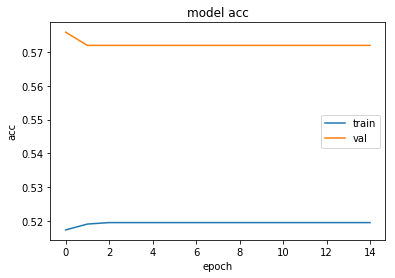

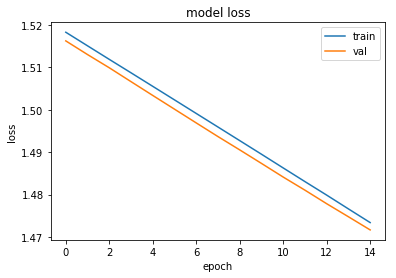

(None, None)

In [72]:
plot_train_val(c2, 'acc'), plot_train_val(c2, 'loss')

In [73]:
y_pred_test =  classifier2.predict_classes(X_test, batch_size=20, verbose=0)

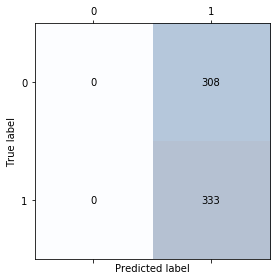

In [74]:
confmat = confusion_matrix(np.argmax(y_test,axis=1), y_pred_test)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()


# Possible Tuning

In [76]:
import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(Dense(12, input_dim=803, activation='tanh'))
    model.add(Dense(2, activation='softmax'))
    # Compile model
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)



# create model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=20, verbose=0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]

param_grid = dict(learn_rate=learn_rate, momentum=momentum)

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [78]:
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
# Function to create model, required for KerasClassifier
def create_model(neurons=1):
# create model
    model = Sequential()
    model.add(Dense(neurons, input_dim=803, kernel_initializer='uniform', activation='tanh', kernel_constraint=maxnorm(4)))
    model.add(Dropout(0.2))
#     model.add(Dense(neurons, kernel_initializer='uniform', activation='tanh', kernel_constraint=maxnorm(4)))
#     model.add(Dropout(0.1))    
    model.add(Dense(2, kernel_initializer='uniform', activation='softmax'))
# Compile model
    adam = optimizers.Adam(lr=.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)


# split into input (X) and output (Y) variables


# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)
# define the grid search parameters
neurons = [2, 5, 10, 15, 20, 25, 30]
param_grid = dict(neurons=neurons)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.506825 using {'neurons': 2}
0.506825 (0.015448) with: {'neurons': 2}
0.500975 (0.011525) with: {'neurons': 5}
0.506435 (0.005984) with: {'neurons': 10}
0.500195 (0.012871) with: {'neurons': 15}
0.504095 (0.018953) with: {'neurons': 20}
0.504095 (0.012186) with: {'neurons': 25}
0.499025 (0.016688) with: {'neurons': 30}


### Only polarity model

In [132]:
len(X_pol)

3

In [125]:
s1 = df_2.polarity.values
s2 = df_2.retweet_from.values
s3 = df_2.tweet_length.values
X_pol = pd.DataFrame([s1,s2,s3]).as_matrix()

In [133]:
X_train_pol, X_test_pol, y_train, y_test = train_test_split(X_pol.T, y, test_size = 0.20, random_state = 42)

In [136]:
classifier3 = Sequential()
# randuni = initializers.VarianceScaling(scale=.3, distribution='normal', seed=None) # RandomUniform(minval=-0.05, maxval=0.05, seed=None)
classifier3.add(Dense(5, input_dim=3, kernel_initializer='normal', activation = 'tanh'))
# classifier3.add(Dense(15, activation = 'tanh'))
# classifier3.add(Dense(5, activation = 'tanh'))
# classifier2.add(Dense(50, kernel_regularizer=regularizers.l1(0.05), activation='tanh'))
# classifier2.add(Dense(10, kernel_regularizer=regularizers.l1(0.05), activation='tanh'))
# classifier3.add(Dense(5, kernel_regularizer=regularizers.l1(0.05), activation='relu'))
# classifier3.add(Dense(5, activation = 'tanh'))
# classifier.add(Dense(5, activation = 'tanh'))
classifier3.add(Dense(2, activation = 'softmax'))
adam = optimizers.Adam(lr=.001)
classifier3.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['accuracy']) 

In [137]:
c3 = classifier3.fit(X_train_pol, y_train, epochs=15, validation_split=.1,
                     batch_size=20, verbose=1)

Train on 2307 samples, validate on 257 samples
Epoch 1/15
2307/2307 [==============================] - 1s 461us/step - loss: 0.6946 - acc: 0.4840 - val_loss: 0.6883 - val_acc: 0.5992
Epoch 2/15
2307/2307 [==============================] - 0s 79us/step - loss: 0.6926 - acc: 0.5130 - val_loss: 0.6885 - val_acc: 0.5992
Epoch 3/15
2307/2307 [==============================] - 0s 73us/step - loss: 0.6926 - acc: 0.5074 - val_loss: 0.6907 - val_acc: 0.5292
Epoch 4/15
2307/2307 [==============================] - 0s 71us/step - loss: 0.6927 - acc: 0.4991 - val_loss: 0.6897 - val_acc: 0.5370
Epoch 5/15
2307/2307 [==============================] - 0s 65us/step - loss: 0.6926 - acc: 0.5117 - val_loss: 0.6923 - val_acc: 0.5331
Epoch 6/15
2307/2307 [==============================] - 0s 66us/step - loss: 0.6925 - acc: 0.5113 - val_loss: 0.6901 - val_acc: 0.5447
Epoch 7/15
2307/2307 [==============================] - 0s 61us/step - loss: 0.6926 - acc: 0.5139 - val_loss: 0.6900 - val_acc: 0.5409
Epoch 8

In [138]:
classifier3_score_no_tweet, classifier3_acc_no_tweet = classifier3.evaluate(X_test_pol, y_test, verbose = 2, batch_size = 32)
print("score for the test data polarity model: %.7f" % (classifier3_score_no_tweet))
print("acc for the test data polarity model: %.7f" % (classifier3_acc_no_tweet))

classifier3_score_train_no_tweet, classifier3_acc_train_no_tweet = classifier3.evaluate(X_train_pol, y_train, verbose = 2, batch_size = 32)
print("score for the training data polarity model: %.7f" % (classifier3_score_train_no_tweet))
print("acc for the training data polarity model: %.7f" % (classifier3_acc_train_no_tweet))

score for the test data polarity model: 0.6923573
acc for the test data polarity model: 0.5304212
score for the training data polarity model: 0.6919562
acc for the training data polarity model: 0.5177457


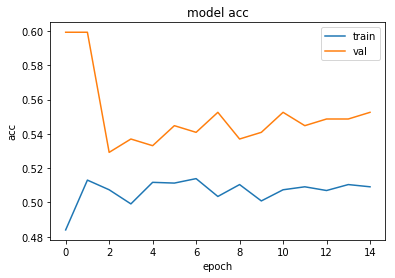

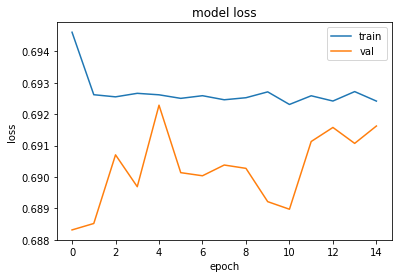

(None, None)

In [139]:
plot_train_val(c3, 'acc'), plot_train_val(c3, 'loss')

In [140]:
y_pred_test3 =  classifier3.predict_classes(X_test_pol, batch_size=20, verbose=0)

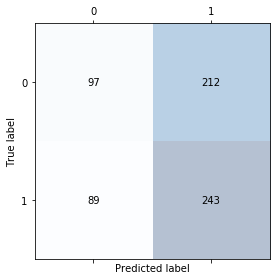

In [141]:
confmat = confusion_matrix(np.argmax(y_test, axis=1), y_pred_test3)

fig, ax = plt.subplots(figsize=(4, 4))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

In [127]:
# X_pol

In [128]:
# df_2.head()